In [2]:
import seaborn
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import numpy as np
seaborn.set_style("darkgrid")

In [5]:
df = pd.read_csv("/Users/david.ellis/Box Sync/Aizenberg_Documents/Papers/csmooth/results/fsl_stats_task-lefthand.csv", index_col=0)
# df = df.set_index([ "smoothing_method", "region", "fwhm", "subject", "run"])

In [6]:
df_indexed = df.set_index(["region", "smoothing_method", "fwhm", "subject", "run"])
wmgm_ratio_df = df_indexed.xs("gm")/df_indexed.xs("wm")
wmgm_ratio_df.reset_index(inplace=True)
wmgm_ratio_df["region"] = "gm_wm"

postcentral_precentral_ratio_df = df_indexed.xs("rh_postcentral")/df_indexed.xs("rh_precentral")
postcentral_precentral_ratio_df.reset_index(inplace=True)
postcentral_precentral_ratio_df["region"] = "rh_postcentral_rh_precentral"

# postcentral_background_ratio_df = df_indexed.xs("rh_postcentral")/df_indexed.xs("background")
# postcentral_background_ratio_df.reset_index(inplace=True)
# postcentral_background_ratio_df["region"] = "rh_postcentral_background"

df = pd.concat([df, wmgm_ratio_df, 
                postcentral_precentral_ratio_df, 
                # postcentral_background_ratio_df
                ], axis=0)

In [7]:
stats = list()
for region in np.unique(df["region"]):
    print(region)
    tmp_df = df[df["region"] == region]
    tmp_df.loc[:, "n_active"] = (tmp_df["n_active"] - tmp_df["n_active"].mean())/ tmp_df["n_active"].std()
    model = smf.mixedlm(f"n_active ~ fwhm + C(smoothing_method, Treatment(reference='Gaussian')):fwhm", 
                        tmp_df, 
                        groups="subject",
                        re_formula="1",
                        vc_formula={"run": "0 + C(run)"})
    result = model.fit()
    stats.append([region, result.fe_params.loc["fwhm"], 
                  result.pvalues.loc["fwhm"],
                  result.conf_int().loc["fwhm", 0],
                  result.conf_int().loc["fwhm", 1],
                  result.fe_params.values[2], 
                  result.pvalues.values[2],
                  result.conf_int().values[2, 0],
                  result.conf_int().values[2, 1]
                  ])
    print(result.summary())

background
                                       Mixed Linear Model Regression Results
Model:                                 MixedLM                     Dependent Variable:                     n_active 
No. Observations:                      420                         Method:                                 REML     
No. Groups:                            10                          Scale:                                  0.0949   
Min. group size:                       42                          Log-Likelihood:                         -157.6161
Max. group size:                       42                          Converged:                              Yes      
Mean group size:                       42.0                                                                         
--------------------------------------------------------------------------------------------------------------------
                                                                         Coef.  Std.Err.    z

/Users/david.ellis/miniconda3/envs/unet/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/david.ellis/miniconda3/envs/unet/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/david.ellis/miniconda3/envs/unet/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                                       Mixed Linear Model Regression Results
Model:                                 MixedLM                     Dependent Variable:                     n_active 
No. Observations:                      420                         Method:                                 REML     
No. Groups:                            10                          Scale:                                  0.1259   
Min. group size:                       42                          Log-Likelihood:                         -217.7333
Max. group size:                       42                          Converged:                              Yes      
Mean group size:                       42.0                                                                         
--------------------------------------------------------------------------------------------------------------------
                                                                         Coef.  Std.Err.    z    P>|z| [

/Users/david.ellis/miniconda3/envs/unet/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/david.ellis/miniconda3/envs/unet/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


                                       Mixed Linear Model Regression Results
Model:                                MixedLM                     Dependent Variable:                     n_active 
No. Observations:                     420                         Method:                                 REML     
No. Groups:                           10                          Scale:                                  0.0770   
Min. group size:                      42                          Log-Likelihood:                         -121.4265
Max. group size:                      42                          Converged:                              Yes      
Mean group size:                      42.0                                                                         
-------------------------------------------------------------------------------------------------------------------
                                                                         Coef.  Std.Err.   z    P>|z| [0.025 0.

/Users/david.ellis/miniconda3/envs/unet/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [8]:
stats_df = pd.DataFrame(stats, 
             columns=["region", "Gaussian_slope", "Gaussian_pval", "Gaussian_ci_low", "Gaussian_ci_high",
                      "constrained_interaction_slope", "constrained_pval", "constrained_ci_low", "constrained_ci_high"])
stats_df["Constrained_slope"] = stats_df["Gaussian_slope"] + stats_df["constrained_interaction_slope"]
stats_df["Constrained_ci_low"] = stats_df["Gaussian_ci_low"] + stats_df["constrained_ci_low"]
stats_df["Constrained_ci_high"] = stats_df["Gaussian_ci_high"] + stats_df["constrained_ci_high"]
# reorder the rows
stats_df = stats_df.set_index("region")
stats_df = stats_df.loc[["gm_wm",
                         # "rh_postcentral_background",
                         "rh_postcentral_rh_precentral",
                         "background",
                         "wm",
                         "gm",
                         "rh_precentral",
                         "rh_postcentral",]]
stats_df.reset_index(inplace=True)
# stats_df.to_csv("/Users/david.ellis/Box Sync/Aizenberg_Documents/Papers/Bayesian/precision/smoothing_hlm_stats.csv", index=False)

In [9]:
stats_df

,region,Gaussian_slope,Gaussian_pval,Gaussian_ci_low,Gaussian_ci_high,constrained_interaction_slope,constrained_pval,constrained_ci_low,constrained_ci_high,Constrained_slope,Constrained_ci_low,Constrained_ci_high
0,gm_wm,-0.090236,1.679977e-54,-0.101612,-0.078859,0.073909,8.373591e-63,0.065249,0.082570,-0.016326,-0.036363,0.003710
1,rh_postcentral_rh_precentral,0.013513,5.719170e-03,0.003929,0.023097,0.012258,9.917608e-04,0.004962,0.019554,0.025770,0.008891,0.042650
2,background,0.151230,5.193126e-198,0.141357,0.161103,-0.097015,3.365637e-141,-0.104531,-0.089499,0.054215,0.036825,0.071604
3,wm,0.060215,3.476389e-40,0.051321,0.069109,-0.021199,8.436794e-10,-0.027969,-0.014428,0.039016,0.023351,0.054681
4,gm,0.054767,6.111860e-66,0.048509,0.061025,-0.014974,7.269527e-10,-0.019739,-0.010210,0.039793,0.028770,0.050815
5,rh_precentral,0.078186,1.788053e-92,0.070673,0.085699,-0.013909,1.875809e-06,-0.019629,-0.008190,0.064277,0.051044,0.077509
6,rh_postcentral,0.087819,2.552248e-199,0.082105,0.093533,-0.015853,9.172661e-13,-0.020203,-0.011503,0.071966,0.061902,0.082031


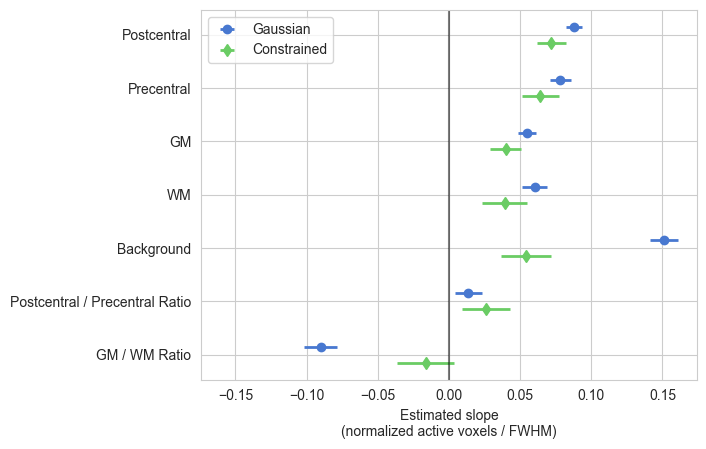

In [10]:
seaborn.set_palette("muted")
seaborn.set_style("whitegrid")
stats_df["region_numeric"] = np.arange(len(stats_df))
offset = 0.15
# plot guassian vs constrained slopes using a forest plot
fig, ax = plt.subplots()
ax.errorbar(stats_df["Gaussian_slope"], 
            stats_df["region_numeric"] + offset, 
            label="Gaussian", 
            xerr=[stats_df["Gaussian_slope"] - stats_df["Gaussian_ci_low"], 
                  stats_df["Gaussian_ci_high"] - stats_df["Gaussian_slope"]],
            fmt="o", capsize=0, elinewidth=2,
            color="C0")
ax.errorbar(stats_df["Constrained_slope"],
            stats_df["region_numeric"] - offset, 
            label="Constrained", 
            xerr=[stats_df["Constrained_slope"] - stats_df["Constrained_ci_low"], 
                  stats_df["Constrained_ci_high"] - stats_df["Constrained_slope"]],
            fmt="d", capsize=0, elinewidth=2,
            color="C2")
# ax.scatter(stats_df["Constrained_slope"], stats_df["region"], label="Constrained", marker="o")

xlim_max = np.max(np.abs(ax.get_xlim()))
ax.set_xlim(-xlim_max, xlim_max)
ylim = ax.get_ylim()
ax.vlines(0, *ylim, color="k", linestyle="-", alpha=0.5)
ax.set_ylim(ylim[0], ylim[1])
ax.set_yticks(ax.get_yticks()[1:-1],
              ["GM / WM Ratio",
               "Postcentral / Precentral Ratio", 
               "Background",
               "WM", 
               "GM", 
               "Precentral",
               "Postcentral",
])
# put the legend on the outside of the plot in the upper right corner
ax.legend(loc="upper left")
ax.set_xlabel("Estimated slope\n(normalized active voxels / FWHM)")
fig.savefig("/Users/david.ellis/Box Sync/Aizenberg_Documents/Papers/csmooth/figures/sensory_smoothing_hlm_forest_plot.png", 
            dpi=300, bbox_inches="tight")
fig.savefig("/Users/david.ellis/Box Sync/Aizenberg_Documents/Papers/csmooth/figures/sensory_smoothing_hlm_forest_plot.pdf", 
            bbox_inches="tight")

In [4]:



def test_smoothing_effect(df, dependent_var="n_active"):
    # Fit a hierarchical linear model
    # 'gm_wm_ratio' is the dependent variable
    # 'smoothing_kernel' is the fixed effect
    # 'subject' and 'run' are random effects
    model = smf.mixedlm(f"{dependent_var} ~ smoothing_parameter", 
                        df.reset_index(("smoothing_parameter", "subject", "run"), inplace=False), 
                        groups="subject",
                        re_formula="1",
                        vc_formula={"run": "0 + C(run)"})
    result = model.fit()
    
    # Print the summary of the model
    print(result.summary())
    return result

In [5]:
# ratio_df = df.xs(("constrained", "rh_precentral"))/df.xs(("constrained", "rh_postcentral"))
# ratio_df.reset_index("smoothing_parameter", inplace=False)
# fig, ax = plt.subplots()
# seaborn.violinplot(data=ratio_df.reset_index("smoothing_parameter", inplace=False),
#                    x="smoothing_parameter",
#                    y="mean_zstat")
# ax.set_title("Constrained smoothing")

In [6]:
# fig, ax = plt.subplots()
# seaborn.violinplot(data=ratio_df.reset_index("smoothing_parameter", inplace=False),
#                    x="smoothing_parameter",
#                    y="n_active")
# ax.set_title("Constrained smoothing")

In [7]:
# ratio_df = df.xs(("Gaussian", "rh_precentral"))/df.xs(("Gaussian", "rh_postcentral"))
# ratio_df.reset_index("smoothing_parameter", inplace=False)
# fig, ax = plt.subplots()
# seaborn.violinplot(data=ratio_df.reset_index("smoothing_parameter", inplace=False),
#                    x="smoothing_parameter",
#                    y="mean_zstat")
# ax.set_title("Gaussian smoothing")

In [8]:
# fig, ax = plt.subplots()
# seaborn.violinplot(data=ratio_df.reset_index("smoothing_parameter", inplace=False),
#                    x="smoothing_parameter",
#                    y="n_active")
# ax.set_title("Gaussian smoothing")

## GM / WM active voxel ratio

Gaussian smoothing


/var/folders/y9/z738g_4x31x88tdf3ty159pr0000gq/T/ipykernel_68298/393902953.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  wmgm_ratio_df = df.xs(("Gaussian", "gm"))/df.xs(("Gaussian", "wm"))
/Users/david.ellis/miniconda3/envs/unet/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/david.ellis/miniconda3/envs/unet/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/david.ellis/miniconda3/envs/unet/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/david.ellis/miniconda3/envs/unet/lib/python3.10/site-packages/statsmod

             Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    n_active
No. Observations:    100        Method:                REML    
No. Groups:          10         Scale:                 0.2322  
Min. group size:     10         Log-Likelihood:        -99.8301
Max. group size:     10         Converged:             No      
Mean group size:     10.0                                      
---------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            2.481    0.204  12.162 0.000  2.081  2.881
smoothing_parameter -0.122    0.011 -10.721 0.000 -0.144 -0.100
subject Var          0.001    0.700                            
run Var              0.690    0.587                            

Constrained smoothing


/Users/david.ellis/miniconda3/envs/unet/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/david.ellis/miniconda3/envs/unet/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/david.ellis/miniconda3/envs/unet/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   n_active
No. Observations:     160       Method:               REML    
No. Groups:           10        Scale:                0.0413  
Min. group size:      16        Log-Likelihood:       -32.4556
Max. group size:      16        Converged:            Yes     
Mean group size:      16.0                                    
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            2.326    0.269  8.641 0.000  1.799  2.854
smoothing_parameter -0.033    0.004 -9.392 0.000 -0.040 -0.026
subject Var          0.002    3.348                           
run Var              1.428    2.583                           



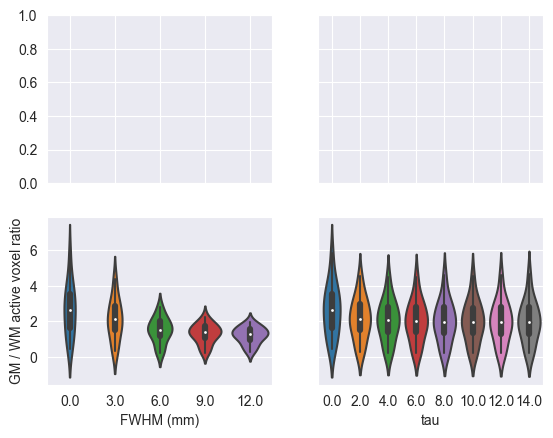

In [9]:
fig, axes = plt.subplots(2, 2, sharey="row", sharex="col")
wmgm_ratio_df = df.xs(("Gaussian", "gm"))/df.xs(("Gaussian", "wm"))
seaborn.violinplot(data=wmgm_ratio_df.reset_index("smoothing_parameter", inplace=False),
                   x="smoothing_parameter",
                   y="n_active", ax=axes[1, 0])
# axes[0, 0].set_title("Gaussian smoothing")
axes[1, 0].set_ylabel("GM / WM active voxel ratio")
axes[1, 0].set_xlabel("FWHM (mm)")
print("Gaussian smoothing")
r1 = test_smoothing_effect(wmgm_ratio_df)
stats.append(["Gaussian", "gm/wm", r1.fe_params.loc["smoothing_parameter"], r1.pvalues.loc["smoothing_parameter"]])
_tmp_wmgm_ratio_df = wmgm_ratio_df
wmgm_ratio_df = df.xs(("constrained", "gm"))/df.xs(("constrained", "wm"))
wmgm_ratio_df = pd.concat([wmgm_ratio_df, _tmp_wmgm_ratio_df.loc[[0.0]]])
seaborn.violinplot(data=wmgm_ratio_df.reset_index("smoothing_parameter", inplace=False),
                   x="smoothing_parameter",
                   y="n_active", ax=axes[1, 1])
# axes[0, 1].set_title("Constrained smoothing")
axes[1, 1].set_ylabel("")
axes[1, 1].set_xlabel("tau")
print("Constrained smoothing")
r2 = test_smoothing_effect(wmgm_ratio_df)
stats.append(["Constrained", "gm/wm", r2.fe_params.loc["smoothing_parameter"], r2.pvalues.loc["smoothing_parameter"]])
import os
os.makedirs("/Users/david.ellis/Box Sync/Aizenberg_Documents/Papers/Bayesian/precision/figures", exist_ok=True)
# fig.savefig("/Users/david.ellis/Box Sync/Aizenberg_Documents/Papers/Bayesian/precision/figures/gm_wm_ratio.png", 
#             dpi=300, bbox_inches="tight")

### GM SNR

In [10]:
# fig, axes = plt.subplots(1, 2, sharey=True)
gm_gauss_df = df.xs(("Gaussian", "gm"))
seaborn.violinplot(data=gm_gauss_df.reset_index("smoothing_parameter", inplace=False),
                   x="smoothing_parameter",
                   y="tSNR", ax=axes[0, 0])
axes[0, 0].set_title("Gaussian smoothing")
axes[0, 0].set_ylabel("GM tSNR")
axes[0, 0].set_xlabel("")
print("Gaussian smoothing")
r1 = test_smoothing_effect(gm_gauss_df, "tSNR")
stats.append(["Gaussian", "GM_tSNR", r1.fe_params.loc["smoothing_parameter"], r1.pvalues.loc["smoothing_parameter"]])
gm_constrained_df = df.xs(("constrained", "gm"))
gm_constrained_df = pd.concat([gm_constrained_df, gm_gauss_df.loc[[0.0]]])
seaborn.violinplot(data=gm_constrained_df.reset_index("smoothing_parameter", inplace=False),
                   x="smoothing_parameter",
                   y="tSNR", ax=axes[0, 1])
axes[0, 1].set_title("Constrained smoothing")
axes[0, 1].set_ylabel("")
axes[0, 1].set_xlabel("")
print("Constrained smoothing")
r2 = test_smoothing_effect(gm_constrained_df, "tSNR")
stats.append(["Constrained", "GM_tSNR", r2.fe_params.loc["smoothing_parameter"], r2.pvalues.loc["smoothing_parameter"]])

fig.savefig("/Users/david.ellis/Box Sync/Aizenberg_Documents/Papers/Bayesian/precision/figures/gmwm_gm_tSNR.png", 
            dpi=300, bbox_inches="tight")

/var/folders/y9/z738g_4x31x88tdf3ty159pr0000gq/T/ipykernel_68298/2693968713.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  gm_gauss_df = df.xs(("Gaussian", "gm"))


Gaussian smoothing


/Users/david.ellis/miniconda3/envs/unet/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/var/folders/y9/z738g_4x31x88tdf3ty159pr0000gq/T/ipykernel_68298/2693968713.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  gm_constrained_df = df.xs(("constrained", "gm"))
/Users/david.ellis/miniconda3/envs/unet/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   tSNR   
No. Observations:     100       Method:               REML   
No. Groups:           10        Scale:                0.0107 
Min. group size:      10        Log-Likelihood:       48.5856
Max. group size:      10        Converged:            Yes    
Mean group size:      10.0                                   
-------------------------------------------------------------
                    Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           4.684    0.133 35.097 0.000  4.423  4.946
smoothing_parameter 0.061    0.002 24.909 0.000  0.056  0.066
subject Var         0.173    0.844                           
run Var             0.004    0.030                           

Constrained smoothing
            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   tSNR   
No. Obser

## Postcentral / Precentral gyrus

### Postcentral / Precentral gyrus active voxel ratio

Gaussian smoothing


/var/folders/y9/z738g_4x31x88tdf3ty159pr0000gq/T/ipykernel_68298/3577470637.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  wmgm_ratio_df = df.xs(("Gaussian", "rh_postcentral"))/df.xs(("Gaussian", "rh_precentral"))


            Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   n_active
No. Observations:    100       Method:               REML    
No. Groups:          10        Scale:                0.0206  
Min. group size:     10        Log-Likelihood:       10.5719 
Max. group size:     10        Converged:            Yes     
Mean group size:     10.0                                    
-------------------------------------------------------------
                    Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           1.125    0.108 10.372 0.000  0.912  1.337
smoothing_parameter 0.006    0.003  1.637 0.102 -0.001  0.012
subject Var         0.058    0.415                           
run Var             0.106    0.364                           

Constrained smoothing


/var/folders/y9/z738g_4x31x88tdf3ty159pr0000gq/T/ipykernel_68298/3577470637.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  wmgm_ratio_df = df.xs(("constrained", "rh_postcentral"))/df.xs(("constrained", "rh_precentral"))


           Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   n_active
No. Observations:   160       Method:               REML    
No. Groups:         10        Scale:                0.0124  
Min. group size:    16        Log-Likelihood:       69.2303 
Max. group size:    16        Converged:            Yes     
Mean group size:    16.0                                    
------------------------------------------------------------
                    Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept           1.139    0.122 9.341 0.000  0.900  1.378
smoothing_parameter 0.003    0.002 1.470 0.142 -0.001  0.007
subject Var         0.063    0.712                          
run Var             0.167    0.702                          



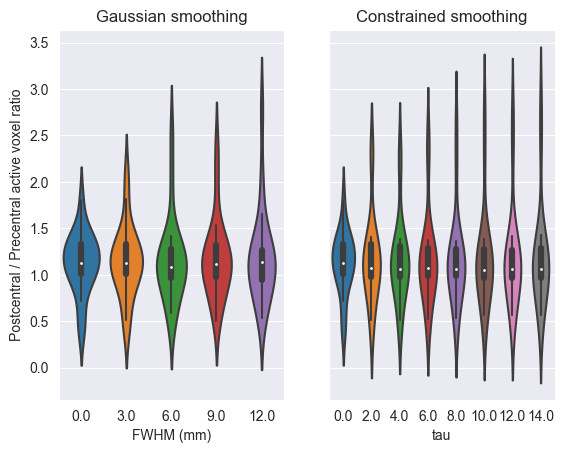

In [11]:
fig, axes = plt.subplots(1, 2, sharey=True)
wmgm_ratio_df = df.xs(("Gaussian", "rh_postcentral"))/df.xs(("Gaussian", "rh_precentral"))
seaborn.violinplot(data=wmgm_ratio_df.reset_index("smoothing_parameter", inplace=False),
                   x="smoothing_parameter",
                   y="n_active", ax=axes[0])
axes[0].set_title("Gaussian smoothing")
axes[0].set_ylabel("Postcentral / Precentral active voxel ratio")
axes[0].set_xlabel("FWHM (mm)")
print("Gaussian smoothing")
r1 = test_smoothing_effect(wmgm_ratio_df, "n_active")
stats.append(["Gaussian", "postcentral/precentral", r1.fe_params.loc["smoothing_parameter"], r1.pvalues.loc["smoothing_parameter"]])
_tmp_wmgm_ratio_df = wmgm_ratio_df
wmgm_ratio_df = df.xs(("constrained", "rh_postcentral"))/df.xs(("constrained", "rh_precentral"))
wmgm_ratio_df = pd.concat([wmgm_ratio_df, _tmp_wmgm_ratio_df.loc[[0.0]]])
seaborn.violinplot(data=wmgm_ratio_df.reset_index("smoothing_parameter", inplace=False),
                   x="smoothing_parameter",
                   y="n_active", ax=axes[1])
axes[1].set_title("Constrained smoothing")
axes[1].set_ylabel("")
axes[1].set_xlabel("tau")
print("Constrained smoothing")
r2 = test_smoothing_effect(wmgm_ratio_df)
stats.append(["Constrained", "postcentral/precentral", r2.fe_params.loc["smoothing_parameter"], r2.pvalues.loc["smoothing_parameter"]])
fig.savefig("/Users/david.ellis/Box Sync/Aizenberg_Documents/Papers/Bayesian/precision/figures/postcentral_precentral_ratio.png", dpi=300, bbox_inches="tight")

### Postcentral / Precentral gyrus (zstat)

In [12]:
# fig, axes = plt.subplots(1, 2, sharey=True)
# wmgm_ratio_df = df.xs(("Gaussian", "rh_postcentral"))/df.xs(("Gaussian", "rh_precentral"))
# seaborn.violinplot(data=wmgm_ratio_df.reset_index("smoothing_parameter", inplace=False),
#                    x="smoothing_parameter",
#                    y="mean_zstat", ax=axes[0])
# axes[0].set_title("Gaussian smoothing")
# axes[0].set_ylabel("Postcentral / Precentral active voxel ratio")
# axes[0].set_xlabel("FWHM (mm)")
# print("Gaussian smoothing")
# test_smoothing_effect(wmgm_ratio_df, "mean_zstat")
# _tmp_wmgm_ratio_df = wmgm_ratio_df
# wmgm_ratio_df = df.xs(("constrained", "rh_postcentral"))/df.xs(("constrained", "rh_precentral"))
# wmgm_ratio_df = pd.concat([wmgm_ratio_df, _tmp_wmgm_ratio_df.loc[[0.0]]])
# seaborn.violinplot(data=wmgm_ratio_df.reset_index("smoothing_parameter", inplace=False),
#                    x="smoothing_parameter",
#                    y="mean_zstat", ax=axes[1])
# axes[1].set_title("Constrained smoothing")
# axes[1].set_ylabel("")
# axes[1].set_xlabel("tau")
# print("Constrained smoothing")
# test_smoothing_effect(wmgm_ratio_df, "mean_zstat")

## Postcentral gyrus

Gaussian smoothing


/var/folders/y9/z738g_4x31x88tdf3ty159pr0000gq/T/ipykernel_68298/3526978054.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  wmgm_ratio_df = df.xs(("Gaussian", "rh_postcentral"))


              Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    n_active 
No. Observations:      100        Method:                REML     
No. Groups:            10         Scale:                 1027.1001
Min. group size:       10         Log-Likelihood:        -522.7370
Max. group size:       10         Converged:             Yes      
Mean group size:       10.0                                       
------------------------------------------------------------------
                     Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
------------------------------------------------------------------
Intercept            229.060   31.377  7.300 0.000 167.562 290.558
smoothing_parameter   12.543    0.755 16.605 0.000  11.063  14.024
subject Var         6304.036  152.490                             
run Var             6465.906   98.794                             

Constrained smoothing


/var/folders/y9/z738g_4x31x88tdf3ty159pr0000gq/T/ipykernel_68298/3526978054.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  wmgm_ratio_df = df.xs(("constrained", "rh_postcentral"))


              Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    n_active 
No. Observations:      160        Method:                REML     
No. Groups:            10         Scale:                 357.5055 
Min. group size:       16         Log-Likelihood:        -746.0415
Max. group size:       16         Converged:             Yes      
Mean group size:       16.0                                       
------------------------------------------------------------------
                     Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
------------------------------------------------------------------
Intercept            249.896   28.713  8.703 0.000 193.619 306.173
smoothing_parameter    4.929    0.326 15.111 0.000   4.290   5.568
subject Var         5350.127  217.648                             
run Var             5639.922  139.211                             



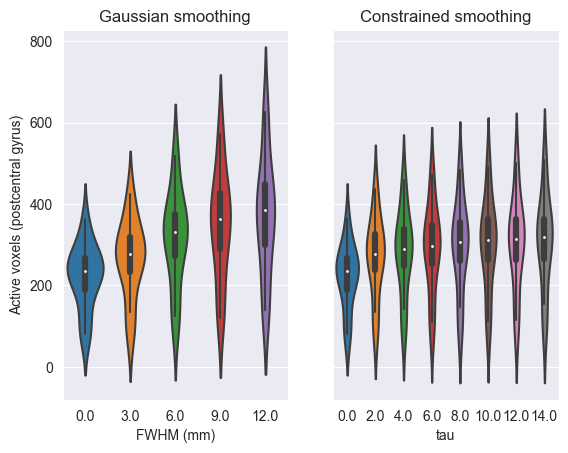

In [13]:
fig, axes = plt.subplots(1, 2, sharey=True)
wmgm_ratio_df = df.xs(("Gaussian", "rh_postcentral"))
seaborn.violinplot(data=wmgm_ratio_df.reset_index("smoothing_parameter", inplace=False),
                   x="smoothing_parameter",
                   y="n_active", ax=axes[0])
axes[0].set_title("Gaussian smoothing")
axes[0].set_ylabel("Active voxels (postcentral gyrus)")
axes[0].set_xlabel("FWHM (mm)")
print("Gaussian smoothing")
r1 = test_smoothing_effect(wmgm_ratio_df, "n_active")
stats.append(["Gaussian", "postcentral", r1.fe_params.loc["smoothing_parameter"], r1.pvalues.loc["smoothing_parameter"]])
_tmp_wmgm_ratio_df = wmgm_ratio_df
wmgm_ratio_df = df.xs(("constrained", "rh_postcentral"))
wmgm_ratio_df = pd.concat([wmgm_ratio_df, _tmp_wmgm_ratio_df.loc[[0.0]]])
seaborn.violinplot(data=wmgm_ratio_df.reset_index("smoothing_parameter", inplace=False),
                   x="smoothing_parameter",
                   y="n_active", ax=axes[1])
axes[1].set_title("Constrained smoothing")
axes[1].set_ylabel("")
axes[1].set_xlabel("tau")
print("Constrained smoothing")
r2 = test_smoothing_effect(wmgm_ratio_df, "n_active")
stats.append(["Constrained", "postcentral", r2.fe_params.loc["smoothing_parameter"], r2.pvalues.loc["smoothing_parameter"]])
fig.savefig("/Users/david.ellis/Box Sync/Aizenberg_Documents/Papers/Bayesian/precision/figures/postcentral.png", dpi=300, bbox_inches="tight")

## Precentral gyrus

/var/folders/y9/z738g_4x31x88tdf3ty159pr0000gq/T/ipykernel_68298/3587353613.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  wmgm_ratio_df = df.xs(("Gaussian", "rh_precentral"))


Gaussian smoothing
               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     n_active 
No. Observations:     100         Method:                 REML     
No. Groups:           10          Scale:                  1719.1039
Min. group size:      10          Log-Likelihood:         -544.8052
Max. group size:      10          Converged:              Yes      
Mean group size:      10.0                                         
-------------------------------------------------------------------
                      Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-------------------------------------------------------------------
Intercept             217.270   28.185  7.709 0.000 162.028 272.512
smoothing_parameter    12.025    0.977 12.305 0.000  10.110  13.940
subject Var          1768.981  107.080                             
run Var             11318.799  133.518                             

Constrained smoothing


/var/folders/y9/z738g_4x31x88tdf3ty159pr0000gq/T/ipykernel_68298/3587353613.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  wmgm_ratio_df = df.xs(("constrained", "rh_precentral"))


               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     n_active 
No. Observations:     160         Method:                 REML     
No. Groups:           10          Scale:                  483.0016 
Min. group size:      16          Log-Likelihood:         -768.2132
Max. group size:      16          Converged:              Yes      
Mean group size:      16.0                                         
-------------------------------------------------------------------
                      Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-------------------------------------------------------------------
Intercept             238.729   23.944  9.970 0.000 191.799 285.659
smoothing_parameter     5.142    0.379 13.563 0.000   4.399   5.885
subject Var           563.048  159.738                             
run Var             10139.377  214.960                             



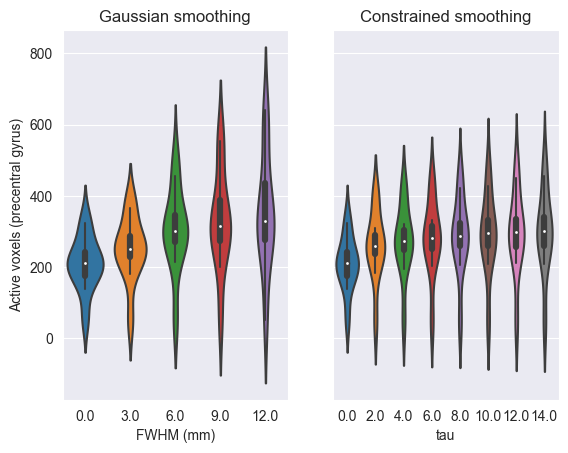

In [14]:
fig, axes = plt.subplots(1, 2, sharey=True)
wmgm_ratio_df = df.xs(("Gaussian", "rh_precentral"))
seaborn.violinplot(data=wmgm_ratio_df.reset_index("smoothing_parameter", inplace=False),
                   x="smoothing_parameter",
                   y="n_active", ax=axes[0])
axes[0].set_title("Gaussian smoothing")
axes[0].set_ylabel("Active voxels (precentral gyrus)")
axes[0].set_xlabel("FWHM (mm)")
print("Gaussian smoothing")
r1 = test_smoothing_effect(wmgm_ratio_df, "n_active")
stats.append(["Gaussian", "precentral", r1.fe_params.loc["smoothing_parameter"], r1.pvalues.loc["smoothing_parameter"]])
_tmp_wmgm_ratio_df = wmgm_ratio_df
wmgm_ratio_df = df.xs(("constrained", "rh_precentral"))
wmgm_ratio_df = pd.concat([wmgm_ratio_df, _tmp_wmgm_ratio_df.loc[[0.0]]])
seaborn.violinplot(data=wmgm_ratio_df.reset_index("smoothing_parameter", inplace=False),
                   x="smoothing_parameter",
                   y="n_active", ax=axes[1])
axes[1].set_title("Constrained smoothing")
axes[1].set_ylabel("")
axes[1].set_xlabel("tau")
print("Constrained smoothing")
r2 = test_smoothing_effect(wmgm_ratio_df)
stats.append(["Constrained", "precentral", r2.fe_params.loc["smoothing_parameter"], r2.pvalues.loc["smoothing_parameter"]])
fig.savefig("/Users/david.ellis/Box Sync/Aizenberg_Documents/Papers/Bayesian/precision/figures/precentral.png", dpi=300, bbox_inches="tight")

In [15]:
stats_df = pd.DataFrame(stats, columns=["smoothing_method", "region", "slope", "pval"])
stats_df.to_csv("/Users/david.ellis/Box Sync/Aizenberg_Documents/Papers/Bayesian/precision/smoothing_hlm_stats.csv")
stats_df

,smoothing_method,region,slope,pval
0,Gaussian,gm/wm,-0.121761,8.105833e-27
1,Constrained,gm/wm,-0.032919,5.911080e-21
2,Gaussian,GM_tSNR,0.060799,5.962394e-137
3,Constrained,GM_tSNR,0.054618,6.393945e-137
4,Gaussian,postcentral/precentral,0.005544,1.016300e-01
5,Constrained,postcentral/precentral,0.002819,1.416148e-01
6,Gaussian,postcentral,12.543333,6.395928e-62
7,Constrained,postcentral,4.929167,1.364268e-51
8,Gaussian,precentral,12.025000,8.547586e-35
9,Constrained,precentral,5.142262,6.654108e-42
